In [19]:
import pennylane as qml
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
# n qubits case
n = 4
m = 2 * n
dev = qml.device('default.qubit', wires=m)

In [21]:
# two qubit case
def real(angles, **kwargs):
    utheta(angles, np.arange(m))

In [22]:
def utheta(w, wires, **kwargs):
    pos = 0
    for i in range(len(wires)):
        qml.RX(w[pos], wires=wires[i])
        qml.RY(w[pos+1], wires=wires[i])
        qml.RZ(w[pos+2], wires=wires[i])
        pos += 3

    for layer in range(4*n):
        for i in range(len(wires)-1):
            qml.CNOT(wires=[wires[i], wires[i+1]])
        qml.CNOT(wires=[wires[len(wires)-1], wires[0]])
        
        for i in range(len(wires)):
            qml.RX(w[pos], wires=wires[i])
            qml.RY(w[pos+1], wires=wires[i])
            qml.RZ(w[pos+2], wires=wires[i])
            pos += 3


In [23]:
@qml.qnode(dev, interface="tf")
def qpca(angles, theta_weights, **kwargs):
    real(angles)
    utheta(theta_weights, list(range(n)))
    z = []
    for i in range(n):
        z.append(qml.expval(qml.PauliZ(i)))
    return z

In [24]:
def pcaloss(angles, theta_weights, **kwargs):
    z = qpca(angles, theta_weights)
    return 1 / 2 ** n / (2 ** n - 1) * tf.math.reduce_sum((z + 1) * (2 ** tf.range(n, dtype=tf.double)))

In [25]:

np.random.seed(0)
#angles = [np.pi / 6, np.pi / 2, np.pi / 7]
n_angles = (m + 1) * 3 * m * 4
angles = np.array([0] * n_angles) + \
                   np.random.normal(scale=np.pi, size=(n_angles,))


eps = 1e-2
n_param = (n + 1) * 3 * n * 4
init_theta_weights = np.array([0] * n_param) + \
                   np.random.normal(scale=eps, size=(n_param,))
theta_weights = tf.Variable(init_theta_weights)

opt = tf.keras.optimizers.Adam(0.1)

In [26]:
@qml.qnode(dev, interface="tf")
def show_real(angles, **kwargs):
    real(angles)
    return qml.density_matrix(list(range(n)))
real_matrix = show_real(angles).numpy()
U, S, V = np.linalg.svd(real_matrix)
print(S)
minloss = np.sum(S * np.arange(len(S))) / 2 ** n / (2 ** n - 1) * 2
print(minloss)

[2.17700316e-01 1.81401684e-01 1.38392838e-01 1.19328333e-01
 8.64941820e-02 6.76431777e-02 4.87401697e-02 4.05142797e-02
 2.96022492e-02 2.53171071e-02 1.91009725e-02 1.15756290e-02
 8.28834778e-03 4.12904668e-03 1.68351381e-03 8.81536456e-05]
0.02531207359861974


Step 0: cost = 0.05972745399132313
Step 5: cost = 0.03987241029253147
Step 10: cost = 0.0349312862709074
Step 15: cost = 0.03117899394354293
Step 20: cost = 0.02935083427828682
Step 25: cost = 0.028590465619585156
Step 30: cost = 0.027845975267947715
Step 35: cost = 0.02716736118517131
Step 40: cost = 0.026868752537415323
Step 45: cost = 0.026638354313250144
Step 50: cost = 0.026442508102610035
Step 55: cost = 0.02626853035070505
Step 60: cost = 0.02612353853073167
Step 65: cost = 0.026009022520705354
Step 70: cost = 0.025929254030320325
Step 75: cost = 0.025875102593424456
Step 80: cost = 0.02583755620382906
Step 85: cost = 0.025806523428717847
Step 90: cost = 0.025780019712032223
Step 95: cost = 0.025755263809961012
Step 100: cost = 0.025732897821936943
Step 105: cost = 0.02571234830504016
Step 110: cost = 0.0256929878082001
Step 115: cost = 0.025675287961825263
Step 120: cost = 0.025659021717025787
Step 125: cost = 0.025644116402364345
Step 130: cost = 0.025630526915532192
Step 135:

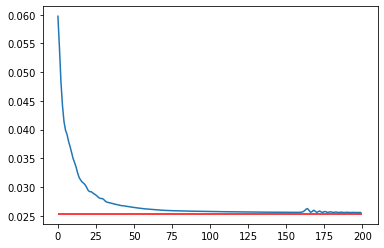

In [27]:
cost = lambda: pcaloss(angles, theta_weights)
n_step = 200
cost_list = []
for step in range(n_step):
    opt.minimize(cost, theta_weights)
    cost_val = cost().numpy()
    cost_list.append(cost_val)
    if step % 5 == 0:
        print("Step {}: cost = {}".format(step, cost_val))
plt.plot(np.arange(n_step), cost_list)
plt.hlines(minloss, 0, n_step, color='r')
plt.show()

In [28]:
@qml.qnode(dev, interface="tf")
def show_real_diag(angles, theta_weights, **kwargs):
    real(angles)
    utheta(theta_weights, list(range(n)))
    return qml.density_matrix(list(range(n)))

[2.17700316e-01 1.81401684e-01 1.38392838e-01 1.19328333e-01
 8.64941820e-02 6.76431777e-02 4.87401697e-02 4.05142797e-02
 2.96022492e-02 2.53171071e-02 1.91009725e-02 1.15756290e-02
 8.28834778e-03 4.12904668e-03 1.68351381e-03 8.81536456e-05]
[0.21759384 0.18101581 0.13657117 0.12119664 0.08604379 0.06773463
 0.0477278  0.03614732 0.03429207 0.02591851 0.01871034 0.01056206
 0.00813931 0.00348831 0.00256904 0.00228936]


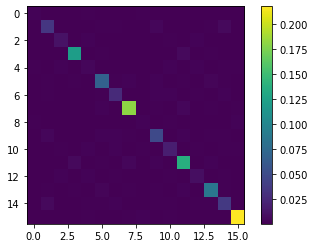

In [29]:
print(S)
print(-np.sort(-np.abs(np.diag(show_real_diag(angles, theta_weights).numpy()))))
plt.imshow(np.abs(show_real_diag(angles, theta_weights).numpy()))
plt.colorbar()
plt.show()